In [1]:
import numpy as np
import pandas as pd
import data_analysis_temp as da
import plotly.express as px
import plotly.graph_objects as go
from ast import literal_eval
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image
import kaleido


In [2]:
user_data, top50 = da.load_data()

/Users/leksa/Documents/MIR/TSAI Hackathon/data-visualisation-web/src/data_analysis_temp.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_50 = top_50.append(df, ignore_index=True)
/Users/leksa/Documents/MIR/TSAI Hackathon/data-visualisation-web/src/data_analysis_temp.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_50 = top_50.append(df, ignore_index=True)
/Users/leksa/Documents/MIR/TSAI Hackathon/data-visualisation-web/src/data_analysis_temp.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_50 = top_50.append(df, ignore_index=True)
/Users/leksa/Documents/MIR/TSAI Hackathon/data-visualisation-web/src/data_analysis_temp.py:23: FutureWarning: The frame.append method is deprecated and will be removed from

### User Based Analysis

In [3]:
qualitative = ['artist_names','genres','key','mode','speechiness','liveness','user_id']
quantative_normalizable = ['popularity', 'danceability', 'energy', 'loudness','speechiness',
       'acousticness', 'instrumentalness', 'valence', 'mode']
quantative_not_normalizable = ['tempo', 'duration_ms','user_id']
# relative way of normalizing - more distinctive result / shows more persona
quantative_normalized = top50[quantative_normalizable].apply(lambda x: (x - x.mean())/x.std(), axis = 0)
# absolute way of normalizing - range is [0,1], less distinctive result / a couple of features are similar among users: energy, loudness, valence, etc. 
# quantative_normalized = (top50[quantative_normalizable] - top50[quantative_normalizable].min())/(top50[quantative_normalizable].max()-top50[quantative_normalizable].min())
quantative_top50 = pd.concat([top50[quantative_not_normalizable],quantative_normalized], axis = 1 )

##### Averaging each feature for each user
user_average_data = quantative_top50.groupby(["user_id"]).mean()
user_average_data = user_average_data.join(top50[["user_id", "artist_names","genres"]].groupby(["user_id"]).nunique(), on = 'user_id')
# using 3 criteria: 
# 1. popularity
# 2. dance music lover: 0.6 * danceability + 0.3 * loudness + 0.3 * energy - 0.2 * acousticness
# 3. musical positiveness: 0.8 * valence + 0.2 * mode
# mode -> 1: major key, mode -> 0: minor key
user_average_data["dance_music_lover"] = user_average_data["danceability"] * 0.6 + user_average_data["loudness"] * 0.3 + user_average_data["energy"] * 0.3 - user_average_data["acousticness"] * 0.2
user_average_data["musical_positiveness"] = user_average_data["valence"] * 0.8 + user_average_data["mode"] * 0.2

user_average_data["user_name"] = user_average_data.index.map(lambda x: user_data[x]["displayName"])

##### Plotting

fig = px.scatter_3d(user_average_data, x = 'dance_music_lover', y = 'musical_positiveness', z = 'popularity', color = 'user_name', size = 'genres', size_max = 30,
                        opacity = 0.7, labels = {'user_name': 'Username', 'dance_music_lover': 'Loves Dance Music', 'musical_positiveness': 'Enjoys Happy Music', 'popularity': 'Listens to Popular Songs',
                                                 'genres': 'Unique Numbers of Genres'}, title = 'User Profile Relative to the Community' )
    
    

fig.update_layout(margin = dict(l=0, r=0, b=0, t=0), coloraxis_colorbar=dict(yanchor="top", y=1, x=0, ticks="outside"))

    

In [4]:
user_average_data.index

Index(['11121022206', '11121236071', '11128397534',
       '21d64nvnthanjsi46jx2qlksq', '22dsoiteluvsvkjwxzzoc7fci',
       '22kkfwe46kc2wbdx5z7r2jy2y', '31baorcxv63aup4z737piimrqg4e',
       '31f5ahuyqn372bcczjmv2orty3rm', '31opghsdw4vzh76ui6mvzo4bdy5i',
       '5hlf1b4i938blmub87jctq9fz', 'adrianzuur', 'am2gyzst9z80a8eg4ia1v500p',
       'auroracamo', 'rt92t3e8n412rygzhiv5dca4s', 'thomasrusbjerg',
       'u34cdru9rpdbczgxme15ilbyz', 'yuconner'],
      dtype='object', name='user_id')

### Genre and Artist Based

/var/folders/qz/tdx4m00s7kjbwb7x7ts61f5m0000gn/T/ipykernel_22437/2833428249.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/qz/tdx4m00s7kjbwb7x7ts61f5m0000gn/T/ipykernel_22437/2833428249.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

findfont: Font family ['numans'] not found. Falling back to DejaVu Sans.


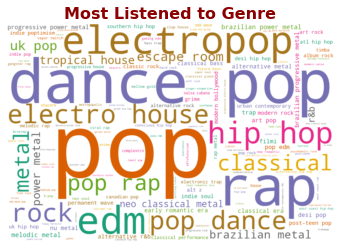

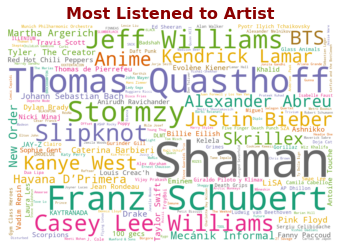

In [5]:
###### Dataframe Cleanup
artist_genre_song = top50[["artist_names", "genres", "name"]]
artist_genre_song["artist_names"] = artist_genre_song["artist_names"].apply(literal_eval)
artist_genre_song["genres"] = artist_genre_song["genres"].apply(literal_eval)
artist_genre_song = artist_genre_song.explode('artist_names')
artist_genre_song = artist_genre_song.explode('genres')
artist_genre_song = artist_genre_song.explode('genres')

###### Creating Ranking for Genres & Artists respectively
genre_rank = artist_genre_song[["genres", "name"]].groupby(["genres"]).nunique().sort_values(by = 'name', ascending=False)
genre_rank = genre_rank[genre_rank["name"] > 5]

artist_rank = artist_genre_song[["artist_names", "name"]].groupby(["artist_names"]).nunique().sort_values(by = 'name', ascending=False)
artist_rank = artist_rank[artist_rank["name"] != 1]

###### Generating WordCloud

for i in [genre_rank, artist_rank]:
    d = i.to_dict()["name"]

    wordcloud = WordCloud(width = 1200, height = 800, background_color = 'white', colormap = 'Dark2')
    wordcloud.generate_from_frequencies(d)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    font = {'family': 'numans',
        'color':  'darkred',
        'weight': 'bold',
        'size': 16,
        }

    if len(i) == len(genre_rank):
        plt.title("Most Listened to Genre", fontdict = font)
        
    else:
        plt.title("Most Listened to Artist", fontdict = font)
        
    
    plt.show()
genre_rank_bar = genre_rank[genre_rank["name"] > 40]
fig_genre = px.bar(genre_rank_bar, x = genre_rank_bar.index, y = 'name', labels = {'genres': 'Genre Name', 'name': "Count of Songs"})
fig_genre.show()
fig_genre.write_image("../images/genre-bar.png")
artist_rank_bar = artist_rank[artist_rank["name"] > 5]
fig_artist = px.bar(artist_rank_bar, x = artist_rank_bar.index, y = 'name', labels = {'artist_names': 'Artist Name', 'name': "Count of Songs"})
fig_artist.show()
fig_artist.write_image("../images/artist-bar.png")


In [6]:
import kaleido